In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="caltech101"
 
model_name="EfficientNetb5_sp"
version = "b5"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=7
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(res,res)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: EfficientNetb5_sp with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch'

In [2]:
globparm=0
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*110*110, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        globparm=xs.shape[1]*xs.shape[2]*xs.shape[3]
        xs = xs.view(-1, globparm)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))




model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

#pretesting model for shape
x=torch.randn(1,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)

torch.Size([1, 3, 456, 456])
torch.Size([1, 101])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [3]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero 

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


torch.Size([7, 101])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 450, 450]           1,184
         MaxPool2d-2          [-1, 8, 225, 225]               0
              ReLU-3          [-1, 8, 225, 225]               0
            Conv2d-4         [-1, 10, 221, 221]           2,010
         MaxPool2d-5         [-1, 10, 110, 110]               0
              ReLU-6         [-1, 10, 110, 110]               0
            Linear-7                   [-1, 32]       3,872,032
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10         [-1, 46, 228, 228]           1,242
      BatchNorm2d-11         [-1, 46, 228, 228]              92
             SiLU-12         [-1, 46, 228, 228]               0
         CNNBlock-13         [-1, 46, 228, 228]               0
           Conv2d-

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb5_sp20220110233549
grandstore_string:
grandstore/caltech101_EfficientNetb5_sp20220110233549.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 10
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=280,
                    minepoch=250,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 7.917
Training Loss: 12244401.9559 	Validation Loss: 5057.8282

Running epoch: 2


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.250
Training Loss: 11977915.3182 	Validation Loss: 5051.3208

Running epoch: 3


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.000
Training Loss: 11898389.2095 	Validation Loss: 5056.7967

Running epoch: 4


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 7.917
Training Loss: 11955430.5764 	Validation Loss: 5049.4173

Running epoch: 5


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.917
Training Loss: 11906834.9685 	Validation Loss: 4975.0766

Running epoch: 6


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 22.667
Training Loss: 11652263.6479 	Validation Loss: 4428.7204

Running epoch: 7


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 28.083
Training Loss: 10591714.6062 	Validation Loss: 4075.8701

Running epoch: 8


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 32.083
Training Loss: 9776061.5063 	Validation Loss: 3813.2965

Running epoch: 9


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 34.083
Training Loss: 9222762.2951 	Validation Loss: 3633.5855

Running epoch: 10


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 38.000
Training Loss: 8746274.3339 	Validation Loss: 3363.3684

Running epoch: 11


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 41.833
Training Loss: 8274314.5872 	Validation Loss: 3103.2277

Running epoch: 12


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.333
Training Loss: 7604300.4180 	Validation Loss: 2952.1837

Running epoch: 13


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.167
Training Loss: 7147494.9347 	Validation Loss: 2817.3440

Running epoch: 14


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 48.083
Training Loss: 6674784.8197 	Validation Loss: 2653.1488

Running epoch: 15


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 51.667
Training Loss: 6272583.5007 	Validation Loss: 2464.4951

Running epoch: 16


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 54.167
Training Loss: 5754252.9339 	Validation Loss: 2394.8944

Running epoch: 17


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 54.667
Training Loss: 5309973.6398 	Validation Loss: 2281.3333

Running epoch: 18


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.000
Training Loss: 4993378.4390 	Validation Loss: 2127.3365

Running epoch: 19


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 4478735.7053 	Validation Loss: 2075.9370

Running epoch: 20


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.167
Training Loss: 4243553.1418 	Validation Loss: 1992.9132

Running epoch: 21


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.833
Training Loss: 3859230.7164 	Validation Loss: 1946.1694

Running epoch: 22


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 3487522.0721 	Validation Loss: 1905.7383

Running epoch: 23


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.250
Training Loss: 3108293.1991 	Validation Loss: 1917.3601

Running epoch: 24


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.167
Training Loss: 2741804.5023 	Validation Loss: 1941.7774

Running epoch: 25


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.917
Training Loss: 2530168.4477 	Validation Loss: 1927.0414

Running epoch: 26


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 2242380.0101 	Validation Loss: 1993.4596

Running epoch: 27


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 1987926.9677 	Validation Loss: 1964.8281

Running epoch: 28


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 1711976.7620 	Validation Loss: 2006.9904

Running epoch: 29


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 1502407.6446 	Validation Loss: 2084.5659

Running epoch: 30


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 1367527.7097 	Validation Loss: 2107.1360

Running epoch: 31


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 1187931.5360 	Validation Loss: 2091.1369

Running epoch: 32


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.917
Training Loss: 1035999.8806 	Validation Loss: 2149.8409

Running epoch: 33


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 974253.8007 	Validation Loss: 2232.7617

Running epoch: 34


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 853301.8103 	Validation Loss: 2296.9531

Running epoch: 35


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 727001.3449 	Validation Loss: 2361.8179

Running epoch: 36


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 751135.9584 	Validation Loss: 2348.6358

Running epoch: 37


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.500
Training Loss: 701246.3742 	Validation Loss: 2406.9201

Running epoch: 38


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 635971.7840 	Validation Loss: 2279.7658

Running epoch: 39


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 64.333
Training Loss: 535960.9145 	Validation Loss: 2505.3198

Running epoch: 40


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 577298.8920 	Validation Loss: 2334.5330

Running epoch: 41


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 560160.2811 	Validation Loss: 2352.3396

Running epoch: 42


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 551137.3395 	Validation Loss: 2375.3200

Running epoch: 43


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 453142.0014 	Validation Loss: 2457.4850

Running epoch: 44


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 64.583
Training Loss: 494621.1716 	Validation Loss: 2508.5212

Running epoch: 45


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 424914.2150 	Validation Loss: 2436.8100

Running epoch: 46


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 477176.3512 	Validation Loss: 2380.6660

Running epoch: 47


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 376863.5697 	Validation Loss: 2519.3243

Running epoch: 48


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 422181.0515 	Validation Loss: 2432.3228

Running epoch: 49


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 451220.5030 	Validation Loss: 2389.3653

Running epoch: 50


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 364716.5200 	Validation Loss: 2482.9085

Running epoch: 51


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 348466.4204 	Validation Loss: 2422.3799

Running epoch: 52


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 327150.8982 	Validation Loss: 2426.3986

Running epoch: 53


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 349500.7551 	Validation Loss: 2465.2660

Running epoch: 54


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 364885.3267 	Validation Loss: 2414.8139

Running epoch: 55


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 280197.4097 	Validation Loss: 2560.9659

Running epoch: 56


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 299968.2933 	Validation Loss: 2646.5514

Running epoch: 57


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 266190.3471 	Validation Loss: 2593.3700

Running epoch: 58


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 298923.4353 	Validation Loss: 2521.7615

Running epoch: 59


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 258141.6990 	Validation Loss: 2548.3920

Running epoch: 60


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 320049.9712 	Validation Loss: 2487.0149

Running epoch: 61


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 299265.2749 	Validation Loss: 2544.3204

Running epoch: 62


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 251791.7014 	Validation Loss: 2582.8669

Running epoch: 63


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 65.250
Training Loss: 247255.4147 	Validation Loss: 2641.8408

Running epoch: 64


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 295310.1516 	Validation Loss: 2662.3592

Running epoch: 65


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 258029.5236 	Validation Loss: 2505.2242

Running epoch: 66


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 186781.5709 	Validation Loss: 2583.2266

Running epoch: 67


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 251502.1445 	Validation Loss: 2594.4019

Running epoch: 68


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 241503.9350 	Validation Loss: 2556.9504

Running epoch: 69


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 226110.5988 	Validation Loss: 2648.4146

Running epoch: 70


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 194845.0161 	Validation Loss: 2654.9928

Running epoch: 71


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 226412.7354 	Validation Loss: 2686.4412

Running epoch: 72


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 222340.4237 	Validation Loss: 2511.1132

Running epoch: 73


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 190762.4091 	Validation Loss: 2655.8240

Running epoch: 74


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 203890.9357 	Validation Loss: 2526.9336

Running epoch: 75


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 197736.5358 	Validation Loss: 2552.0638

Running epoch: 76


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 176806.8210 	Validation Loss: 2535.9829

Running epoch: 77


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 196700.1618 	Validation Loss: 2559.0073

Running epoch: 78


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 170130.0556 	Validation Loss: 2553.7668

Running epoch: 79


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 195819.4612 	Validation Loss: 2645.2670

Running epoch: 80


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 171716.5202 	Validation Loss: 2582.8532

Running epoch: 81


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 175792.7567 	Validation Loss: 2605.0089

Running epoch: 82


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 177689.6114 	Validation Loss: 2768.6865

Running epoch: 83


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 158438.8959 	Validation Loss: 2629.3050

Running epoch: 84


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 178804.3617 	Validation Loss: 2617.9149

Running epoch: 85


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 203282.2851 	Validation Loss: 2511.1843

Running epoch: 86


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 172278.1789 	Validation Loss: 2739.2316

Running epoch: 87


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 176226.0141 	Validation Loss: 2694.1144

Running epoch: 88


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 153068.9809 	Validation Loss: 2675.9080

Running epoch: 89


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 187466.9659 	Validation Loss: 2671.3024

Running epoch: 90


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 164306.9915 	Validation Loss: 2547.6741

Running epoch: 91


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 141344.7257 	Validation Loss: 2658.8452

Running epoch: 92


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 152575.7264 	Validation Loss: 2666.2695

Running epoch: 93


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 160254.9092 	Validation Loss: 2604.6741

Running epoch: 94


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 169400.8804 	Validation Loss: 2650.6140

Running epoch: 95


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 139833.2402 	Validation Loss: 2614.7508

Running epoch: 96


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 126852.8888 	Validation Loss: 2644.1589

Running epoch: 97


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 121557.6946 	Validation Loss: 2679.9355

Running epoch: 98


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 152314.3129 	Validation Loss: 2648.6874

Running epoch: 99


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 102471.3829 	Validation Loss: 2695.6912

Running epoch: 100


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 144820.2716 	Validation Loss: 2735.0539

Running epoch: 101


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 143335.7039 	Validation Loss: 2800.7249

Running epoch: 102


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 141253.7076 	Validation Loss: 2762.4119

Running epoch: 103


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 144998.7105 	Validation Loss: 2693.4526

Running epoch: 104


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 118786.7956 	Validation Loss: 2660.9062

Running epoch: 105


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 158542.6377 	Validation Loss: 2769.3705

Running epoch: 106


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 127247.0331 	Validation Loss: 2683.5891

Running epoch: 107


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 144035.6447 	Validation Loss: 2692.7287

Running epoch: 108


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 119859.5820 	Validation Loss: 2685.8736

Running epoch: 109


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 104056.6837 	Validation Loss: 2755.9351

Running epoch: 110


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 147918.8758 	Validation Loss: 2758.8956

Running epoch: 111


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 135833.2719 	Validation Loss: 2669.8219

Running epoch: 112


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 101695.1090 	Validation Loss: 2541.5746

Running epoch: 113


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 109822.3205 	Validation Loss: 2879.7590

Running epoch: 114


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 104783.3721 	Validation Loss: 2823.9537

Running epoch: 115


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 130456.6821 	Validation Loss: 2840.6916

Running epoch: 116


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 142086.3547 	Validation Loss: 2711.3708

Running epoch: 117


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 123638.5028 	Validation Loss: 2686.2513

Running epoch: 118


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 100179.3987 	Validation Loss: 2690.3091

Running epoch: 119


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 100730.1546 	Validation Loss: 2797.3882

Running epoch: 120


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 125086.5478 	Validation Loss: 2927.0722

Running epoch: 121


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 115354.3002 	Validation Loss: 2781.4253

Running epoch: 122


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 127060.9163 	Validation Loss: 2754.1080

Running epoch: 123


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 95612.5942 	Validation Loss: 2746.8296

Running epoch: 124


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 89391.4361 	Validation Loss: 2906.8233

Running epoch: 125


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 97787.4232 	Validation Loss: 2821.8929

Running epoch: 126


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 156362.2024 	Validation Loss: 2735.4487

Running epoch: 127


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 120576.9550 	Validation Loss: 2749.6146

Running epoch: 128


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 99075.6581 	Validation Loss: 2727.0296

Running epoch: 129


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 86617.8186 	Validation Loss: 2731.9220

Running epoch: 130


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 80737.4345 	Validation Loss: 2704.1614

Running epoch: 131


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 90803.2217 	Validation Loss: 2856.3959

Running epoch: 132


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 133366.1803 	Validation Loss: 2751.3990

Running epoch: 133


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 81169.4478 	Validation Loss: 2737.0872

Running epoch: 134


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 88124.9236 	Validation Loss: 2744.8511

Running epoch: 135


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 102145.8548 	Validation Loss: 2948.3463

Running epoch: 136


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 89649.7546 	Validation Loss: 2886.0213

Running epoch: 137


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 93299.4768 	Validation Loss: 2776.4476

Running epoch: 138


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 99976.7933 	Validation Loss: 3018.2816

Running epoch: 139


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 105362.4216 	Validation Loss: 2784.1808

Running epoch: 140


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 81510.3652 	Validation Loss: 2740.0704

Running epoch: 141


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 105816.4236 	Validation Loss: 2683.6530

Running epoch: 142


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 77767.5056 	Validation Loss: 2736.0792

Running epoch: 143


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 103054.3272 	Validation Loss: 2899.8348

Running epoch: 144


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 99563.9429 	Validation Loss: 2857.3991

Running epoch: 145


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 92439.5435 	Validation Loss: 2743.9572

Running epoch: 146


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.750
Training Loss: 110678.9902 	Validation Loss: 2832.3942

Running epoch: 147


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 96675.8286 	Validation Loss: 2852.2695

Running epoch: 148


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 88996.6876 	Validation Loss: 2908.1751

Running epoch: 149


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 87304.5217 	Validation Loss: 2785.0256

Running epoch: 150


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 94099.6700 	Validation Loss: 2902.8250

Running epoch: 151


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 82268.8369 	Validation Loss: 2794.9780

Running epoch: 152


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 75524.1255 	Validation Loss: 2908.5668

Running epoch: 153


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 97085.9900 	Validation Loss: 2812.2606

Running epoch: 154


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 96305.8317 	Validation Loss: 2708.3367

Running epoch: 155


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 80920.6751 	Validation Loss: 2777.7164

Running epoch: 156


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 102207.5623 	Validation Loss: 2586.0606

Running epoch: 157


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 92935.4427 	Validation Loss: 2735.3198

Running epoch: 158


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.167
Training Loss: 127220.7316 	Validation Loss: 2802.5482

Running epoch: 159


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 80978.3374 	Validation Loss: 2766.6489

Running epoch: 160


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 83533.8216 	Validation Loss: 2764.6518

Running epoch: 161


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 71226.0892 	Validation Loss: 2705.6802

Running epoch: 162


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 75399.2533 	Validation Loss: 2807.0171

Running epoch: 163


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 88130.4967 	Validation Loss: 2858.9424

Running epoch: 164


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 72996.8925 	Validation Loss: 2735.3584

Running epoch: 165


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 114206.9238 	Validation Loss: 2718.1772

Running epoch: 166


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 81719.9153 	Validation Loss: 2755.6209

Running epoch: 167


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 54774.9639 	Validation Loss: 2836.5997

Running epoch: 168


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.750
Training Loss: 95468.9051 	Validation Loss: 2874.9515

Running epoch: 169


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 79592.0851 	Validation Loss: 2934.0635

Running epoch: 170


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 64841.4137 	Validation Loss: 2891.6992

Running epoch: 171


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 74132.8862 	Validation Loss: 3087.6651

Running epoch: 172


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 85737.1280 	Validation Loss: 2858.6748

Running epoch: 173


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 96900.4872 	Validation Loss: 2858.9194

Running epoch: 174


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 92490.1686 	Validation Loss: 2991.2764

Running epoch: 175


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.750
Training Loss: 78039.6362 	Validation Loss: 2909.9730

Running epoch: 176


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 85270.6366 	Validation Loss: 2723.9746

Running epoch: 177


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 89351.2984 	Validation Loss: 2721.9853

Running epoch: 178


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 70699.5768 	Validation Loss: 2696.0669

Running epoch: 179


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 87623.1704 	Validation Loss: 2811.6928

Running epoch: 180


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 59256.6089 	Validation Loss: 2643.8217

Running epoch: 181


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 60014.8482 	Validation Loss: 2687.0703

Running epoch: 182


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 84958.1200 	Validation Loss: 2838.6830

Running epoch: 183


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 74178.1455 	Validation Loss: 3008.6558

Running epoch: 184


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 91894.0925 	Validation Loss: 2726.5087

Running epoch: 185


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 55812.6864 	Validation Loss: 2723.8107

Running epoch: 186


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 35962.2945 	Validation Loss: 2820.5151

Running epoch: 187


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 91787.8158 	Validation Loss: 2792.3417

Running epoch: 188


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 44597.1313 	Validation Loss: 2779.9885

Running epoch: 189


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 102461.9549 	Validation Loss: 2776.4174

Running epoch: 190


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 79655.6603 	Validation Loss: 2716.1553

Running epoch: 191


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 71767.3414 	Validation Loss: 2816.7364

Running epoch: 192


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 88885.7498 	Validation Loss: 2806.3782

Running epoch: 193


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 54743.6125 	Validation Loss: 2930.7930

Running epoch: 194


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 73931.0148 	Validation Loss: 2876.2083

Running epoch: 195


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 38735.7255 	Validation Loss: 2928.2105

Running epoch: 196


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 93749.0716 	Validation Loss: 2928.6868

Running epoch: 197


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 54339.6575 	Validation Loss: 2791.4161

Running epoch: 198


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 74912.8796 	Validation Loss: 2860.0086

Running epoch: 199


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 65059.6390 	Validation Loss: 2927.4633

Running epoch: 200


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 50528.3210 	Validation Loss: 2837.0143

Running epoch: 201


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 78653.8359 	Validation Loss: 2886.0913

Running epoch: 202


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 53591.4364 	Validation Loss: 2738.7150

Running epoch: 203


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 100428.5331 	Validation Loss: 2992.9618

Running epoch: 204


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 75531.2170 	Validation Loss: 2624.4377

Running epoch: 205


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 53356.5902 	Validation Loss: 2794.3091

Running epoch: 206


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 53592.0792 	Validation Loss: 2832.3416

Running epoch: 207


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 50043.1496 	Validation Loss: 2859.6831

Running epoch: 208


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 93182.7064 	Validation Loss: 2823.5880

Running epoch: 209


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 45720.6509 	Validation Loss: 2767.8066

Running epoch: 210


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 68772.1511 	Validation Loss: 2704.3847

Running epoch: 211


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 53321.6445 	Validation Loss: 2785.2574

Running epoch: 212


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 85732.6607 	Validation Loss: 2803.4344

Running epoch: 213


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 50581.9406 	Validation Loss: 2674.5565

Running epoch: 214


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 51662.7347 	Validation Loss: 2784.4737

Running epoch: 215


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 64607.4263 	Validation Loss: 3039.3505

Running epoch: 216


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 88950.9487 	Validation Loss: 2944.4682

Running epoch: 217


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 60929.9669 	Validation Loss: 2898.4642

Running epoch: 218


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 43084.2254 	Validation Loss: 2858.7868

Running epoch: 219


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 50523.8805 	Validation Loss: 2821.5755

Running epoch: 220


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 67370.2919 	Validation Loss: 2876.1487

Running epoch: 221


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 76638.3756 	Validation Loss: 2953.8185

Running epoch: 222


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 53156.0446 	Validation Loss: 3032.7831

Running epoch: 223


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 49880.0458 	Validation Loss: 2895.2968

Running epoch: 224


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 72042.8634 	Validation Loss: 2913.0592

Running epoch: 225


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 36308.0543 	Validation Loss: 2768.1036

Running epoch: 226


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 82963.7992 	Validation Loss: 2718.9486

Running epoch: 227


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 60041.6991 	Validation Loss: 2870.9143

Running epoch: 228


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 46359.9274 	Validation Loss: 2974.9516

Running epoch: 229


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 72751.8652 	Validation Loss: 2983.9341

Running epoch: 230


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 70976.4598 	Validation Loss: 2980.2033

Running epoch: 231


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 57072.7081 	Validation Loss: 2951.9291

Running epoch: 232


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 52468.0747 	Validation Loss: 2997.6696

Running epoch: 233


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 58807.0122 	Validation Loss: 2789.6553

Running epoch: 234


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 77693.9330 	Validation Loss: 2986.6146

Running epoch: 235


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 45353.7876 	Validation Loss: 2881.8001

Running epoch: 236


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 44428.7806 	Validation Loss: 3069.9093

Running epoch: 237


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 81817.2317 	Validation Loss: 2866.3812

Running epoch: 238


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 38755.7836 	Validation Loss: 2875.1241

Running epoch: 239


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.167
Training Loss: 58551.2954 	Validation Loss: 2984.9519

Running epoch: 240


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 45665.9342 	Validation Loss: 2836.7230

Running epoch: 241


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 80262.1818 	Validation Loss: 2911.6171

Running epoch: 242


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 61011.3802 	Validation Loss: 2793.6915

Running epoch: 243


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 63497.4804 	Validation Loss: 2786.4597

Running epoch: 244


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 41100.6941 	Validation Loss: 2802.0769

Running epoch: 245


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 42289.6876 	Validation Loss: 2925.5944

Running epoch: 246


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 37328.6083 	Validation Loss: 2802.5468

Running epoch: 247


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 67129.9235 	Validation Loss: 3043.9254

Running epoch: 248


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 72218.6986 	Validation Loss: 2937.0507

Running epoch: 249


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 66397.4407 	Validation Loss: 3032.1097

Running epoch: 250


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 43346.1160 	Validation Loss: 3092.3117

Running epoch: 251


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 40279.6681 	Validation Loss: 2927.6918

Running epoch: 252


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 35648.1147 	Validation Loss: 3032.6032

Running epoch: 253


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 30178.6887 	Validation Loss: 3019.4811

Running epoch: 254


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 37670.7812 	Validation Loss: 2969.8788

Running epoch: 255


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 43058.0918 	Validation Loss: 3055.6951

Running epoch: 256


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 64919.4136 	Validation Loss: 3083.6779

Running epoch: 257


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 63050.8666 	Validation Loss: 3041.7734

Running epoch: 258


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 37821.7030 	Validation Loss: 3013.0597

Running epoch: 259


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 54664.0201 	Validation Loss: 2962.2040

Running epoch: 260


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 57858.3909 	Validation Loss: 2958.4329

Running epoch: 261


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 58550.9323 	Validation Loss: 2949.4421

Running epoch: 262


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 46728.6356 	Validation Loss: 2931.8379

Running epoch: 263


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 38477.3486 	Validation Loss: 2963.2258

Running epoch: 264


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 61256.7019 	Validation Loss: 2983.5952

Running epoch: 265


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 79099.2654 	Validation Loss: 3113.4957

Running epoch: 266


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 57130.3051 	Validation Loss: 2973.5129

Running epoch: 267


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 55495.2809 	Validation Loss: 3039.2551

Running epoch: 268


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 58704.5504 	Validation Loss: 3081.4775

Running epoch: 269


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 39348.2349 	Validation Loss: 2870.4024

Running epoch: 270


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 72604.8052 	Validation Loss: 2946.4035

Running epoch: 271


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 57845.2639 	Validation Loss: 2878.2397

Running epoch: 272


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 40025.5505 	Validation Loss: 2996.5394

Running epoch: 273


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 37224.3220 	Validation Loss: 3024.4861

Running epoch: 274


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 42072.8972 	Validation Loss: 2977.6702

Running epoch: 275


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 46755.3480 	Validation Loss: 2956.3521

Running epoch: 276


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 38933.3222 	Validation Loss: 3134.7189

Running epoch: 277


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 57871.4139 	Validation Loss: 3098.8956

Running epoch: 278


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 58486.3620 	Validation Loss: 3224.0275

Running epoch: 279


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 60569.8428 	Validation Loss: 2993.9292

Running epoch: 280


  0%|          | 0/897 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 47321.1506 	Validation Loss: 2810.1056



Total Run 280 epoch(s)
Accuracy MIN: 7.916666666666667 / MAX: 72.75

Top 10 performing epochs:
#1 epoch 237	||train_acc 72.75%	||test 71.67%
#2 epoch 212	||train_acc 72.75%	||test 70.17%
#3 epoch 204	||train_acc 72.42%	||test 71.25%
#4 epoch 280	||train_acc 72.00%	||test 71.83%
#5 epoch 218	||train_acc 72.00%	||test 70.42%
#6 epoch 266	||train_acc 71.92%	||test 70.83%
#7 epoch 250	||train_acc 71.83%	||test 71.58%
#8 epoch 271	||train_acc 71.83%	||test 69.92%
#9 epoch 220	||train_acc 71.83%	||test 69.33%
#10 epoch 253	||train_acc 71.75%	||test 72.08%

Last epoch:
epoch 280	||train_acc 72.00%	||test 71.83%

The model has parameters: 99446815


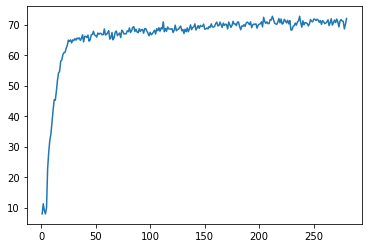

In [8]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [9]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/caltech101_EfficientNetb5_sp20220110233549.pkl
